<center>

# Gausian Naive Bayes From Scratch

</center>

## Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Importing The Dataset

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

data = load_iris()
class_names = data.target_names
feature_names = data.feature_names
X = data.data
Y = data.target
x, x_test, y, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [3]:
DATA = pd.DataFrame(np.column_stack([x, y]), columns=feature_names+["Target"])
DATA

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,4.6,3.6,1.0,0.2,0.0
1,5.7,4.4,1.5,0.4,0.0
2,6.7,3.1,4.4,1.4,1.0
3,4.8,3.4,1.6,0.2,0.0
4,4.4,3.2,1.3,0.2,0.0
...,...,...,...,...,...
115,6.1,2.8,4.0,1.3,1.0
116,4.9,2.5,4.5,1.7,2.0
117,5.8,4.0,1.2,0.2,0.0
118,5.8,2.6,4.0,1.2,1.0


In [4]:
np.sum(DATA["Target"]==0), np.sum(DATA["Target"]==1), np.sum(DATA["Target"]==2)

(np.int64(40), np.int64(41), np.int64(39))

## Gaussian Naive Bayes

### 1. 💡 Basic Idea

Naive Bayes is a **probabilistic classifier** based on **Bayes' theorem** with a strong **naive independence assumption** between features.


### 2. 📜 Bayes’ Theorem

$$
P(C_k \mid \mathbf{x}) = \frac{P(\mathbf{x} \mid C_k) \cdot P(C_k)}{P(\mathbf{x})}
$$

Where:

* $P(C_k \mid \mathbf{x})$: Posterior probability of class $C_k$ given features $\mathbf{x}$
* $P(\mathbf{x} \mid C_k)$: Likelihood of features $\mathbf{x}$ given class $C_k$
* $P(C_k)$: Prior probability of class $C_k$
* $P(\mathbf{x})$: Evidence (same for all classes, can be ignored for comparison)


### 3. 🧠 Naive Assumption

Assume all features $x_i$ are conditionally independent given the class:

$$
P(\mathbf{x} \mid C_k) = \prod_{i=1}^{n} P(x_i \mid C_k)
$$


### 4. 📈 Gaussian Likelihood

For continuous features, we model $P(x_i \mid C_k)$ using a **Gaussian (Normal) distribution**:

$$
P(x_i \mid C_k) = \frac{1}{\sqrt{2 \pi \sigma_{k,i}^2}} \cdot \exp\left(-\frac{(x_i - \mu_{k,i})^2}{2 \sigma_{k,i}^2}\right)
$$

Where:

* $\mu_{k,i}$: Mean of feature $x_i$ for class $C_k$
* $\sigma_{k,i}^2$: Variance of feature $x_i$ for class $C_k$


### 5. 🧮 Log Probability (to prevent underflow)

We use log-likelihood to avoid numerical issues:

$$
\log P(C_k \mid \mathbf{x}) \propto \log P(C_k) + \sum_{i=1}^{n} \log P(x_i \mid C_k)
$$


### 6. 🧷 Prediction Rule

Choose the class with the highest log posterior:

$$
\hat{y} = \arg\max_k \left[ \log P(C_k) + \sum_{i=1}^{n} \log P(x_i \mid C_k) \right]
$$


### 7. 📊 Prior Probability Estimate (from data)

$$
P(C_k) = \frac{\text{Number of samples in class } C_k}{\text{Total number of samples}}
$$


### 8. 📚 Mean and Variance Per Feature (from training data)

$$
\mu_{k,i} = \frac{1}{N_k} \sum_{j=1}^{N_k} x_{j,i}
\quad ; \quad
\sigma_{k,i}^2 = \frac{1}{N_k - 1} \sum_{j=1}^{N_k} (x_{j,i} - \mu_{k,i})^2
$$

Where:

* $N_k$: Number of training samples in class $C_k$
* $x_{j,i}$: $i^{th}$ feature of the $j^{th}$ sample in class $C_k$


### ✅ Summary

* **Train**: Estimate priors, means, and variances from training data.
* **Predict**: Use Gaussian likelihood + log posterior to classify new samples.




In [5]:
DATA = pd.DataFrame(np.column_stack([x, y]), columns=feature_names+["Target"])

def class_prior(DATA):
    
    class_prior_values = []
    for i in range(len(class_names)):
        value = np.sum(DATA["Target"]==i)/len(DATA["Target"])
        class_prior_values.append(value)
    return class_prior_values

def mean_var_per_feature(DATA):
    
    grouped = DATA.groupby("Target")
    class_stats = {}

    for class_label, group in grouped:
        means = group[feature_names].mean().values
        variances = group[feature_names].var().values + 1e-9  # Avoid divide-by-zero
        class_stats[class_label] = {"mean": means, "var": variances}
    
    return class_stats

def normal_distribution(x, mean, var):
    y = (1 / np.sqrt(2 * np.pi * var)) * np.exp(-((x - mean)**2) / (2 * var))
    return y

def GaussianNB(test_point, DATA):
    
    stats = mean_var_per_feature(DATA)
    
    class_prior_values = class_prior(DATA)
    log_prob = 0
    log_prob_values = []
    
    for i in range(len(class_names)):
        mean = stats[i]["mean"]
        variance = stats[i]["var"]
        
        for j in range(len(test_point)):
            log_prob += np.log(normal_distribution(test_point[j], mean[j], variance[j]))
        log_prob += np.log(class_prior_values[i] + 1e-9)
        log_prob_values.append(log_prob)
        log_prob = 0
    
    return np.argmax(log_prob_values)

class_names[GaussianNB(test_point=[4.6, 3.6, 1.0, 0.2], DATA=DATA)].item()

'setosa'

## Plot To See How Well the Data Fits The Normal Distributions

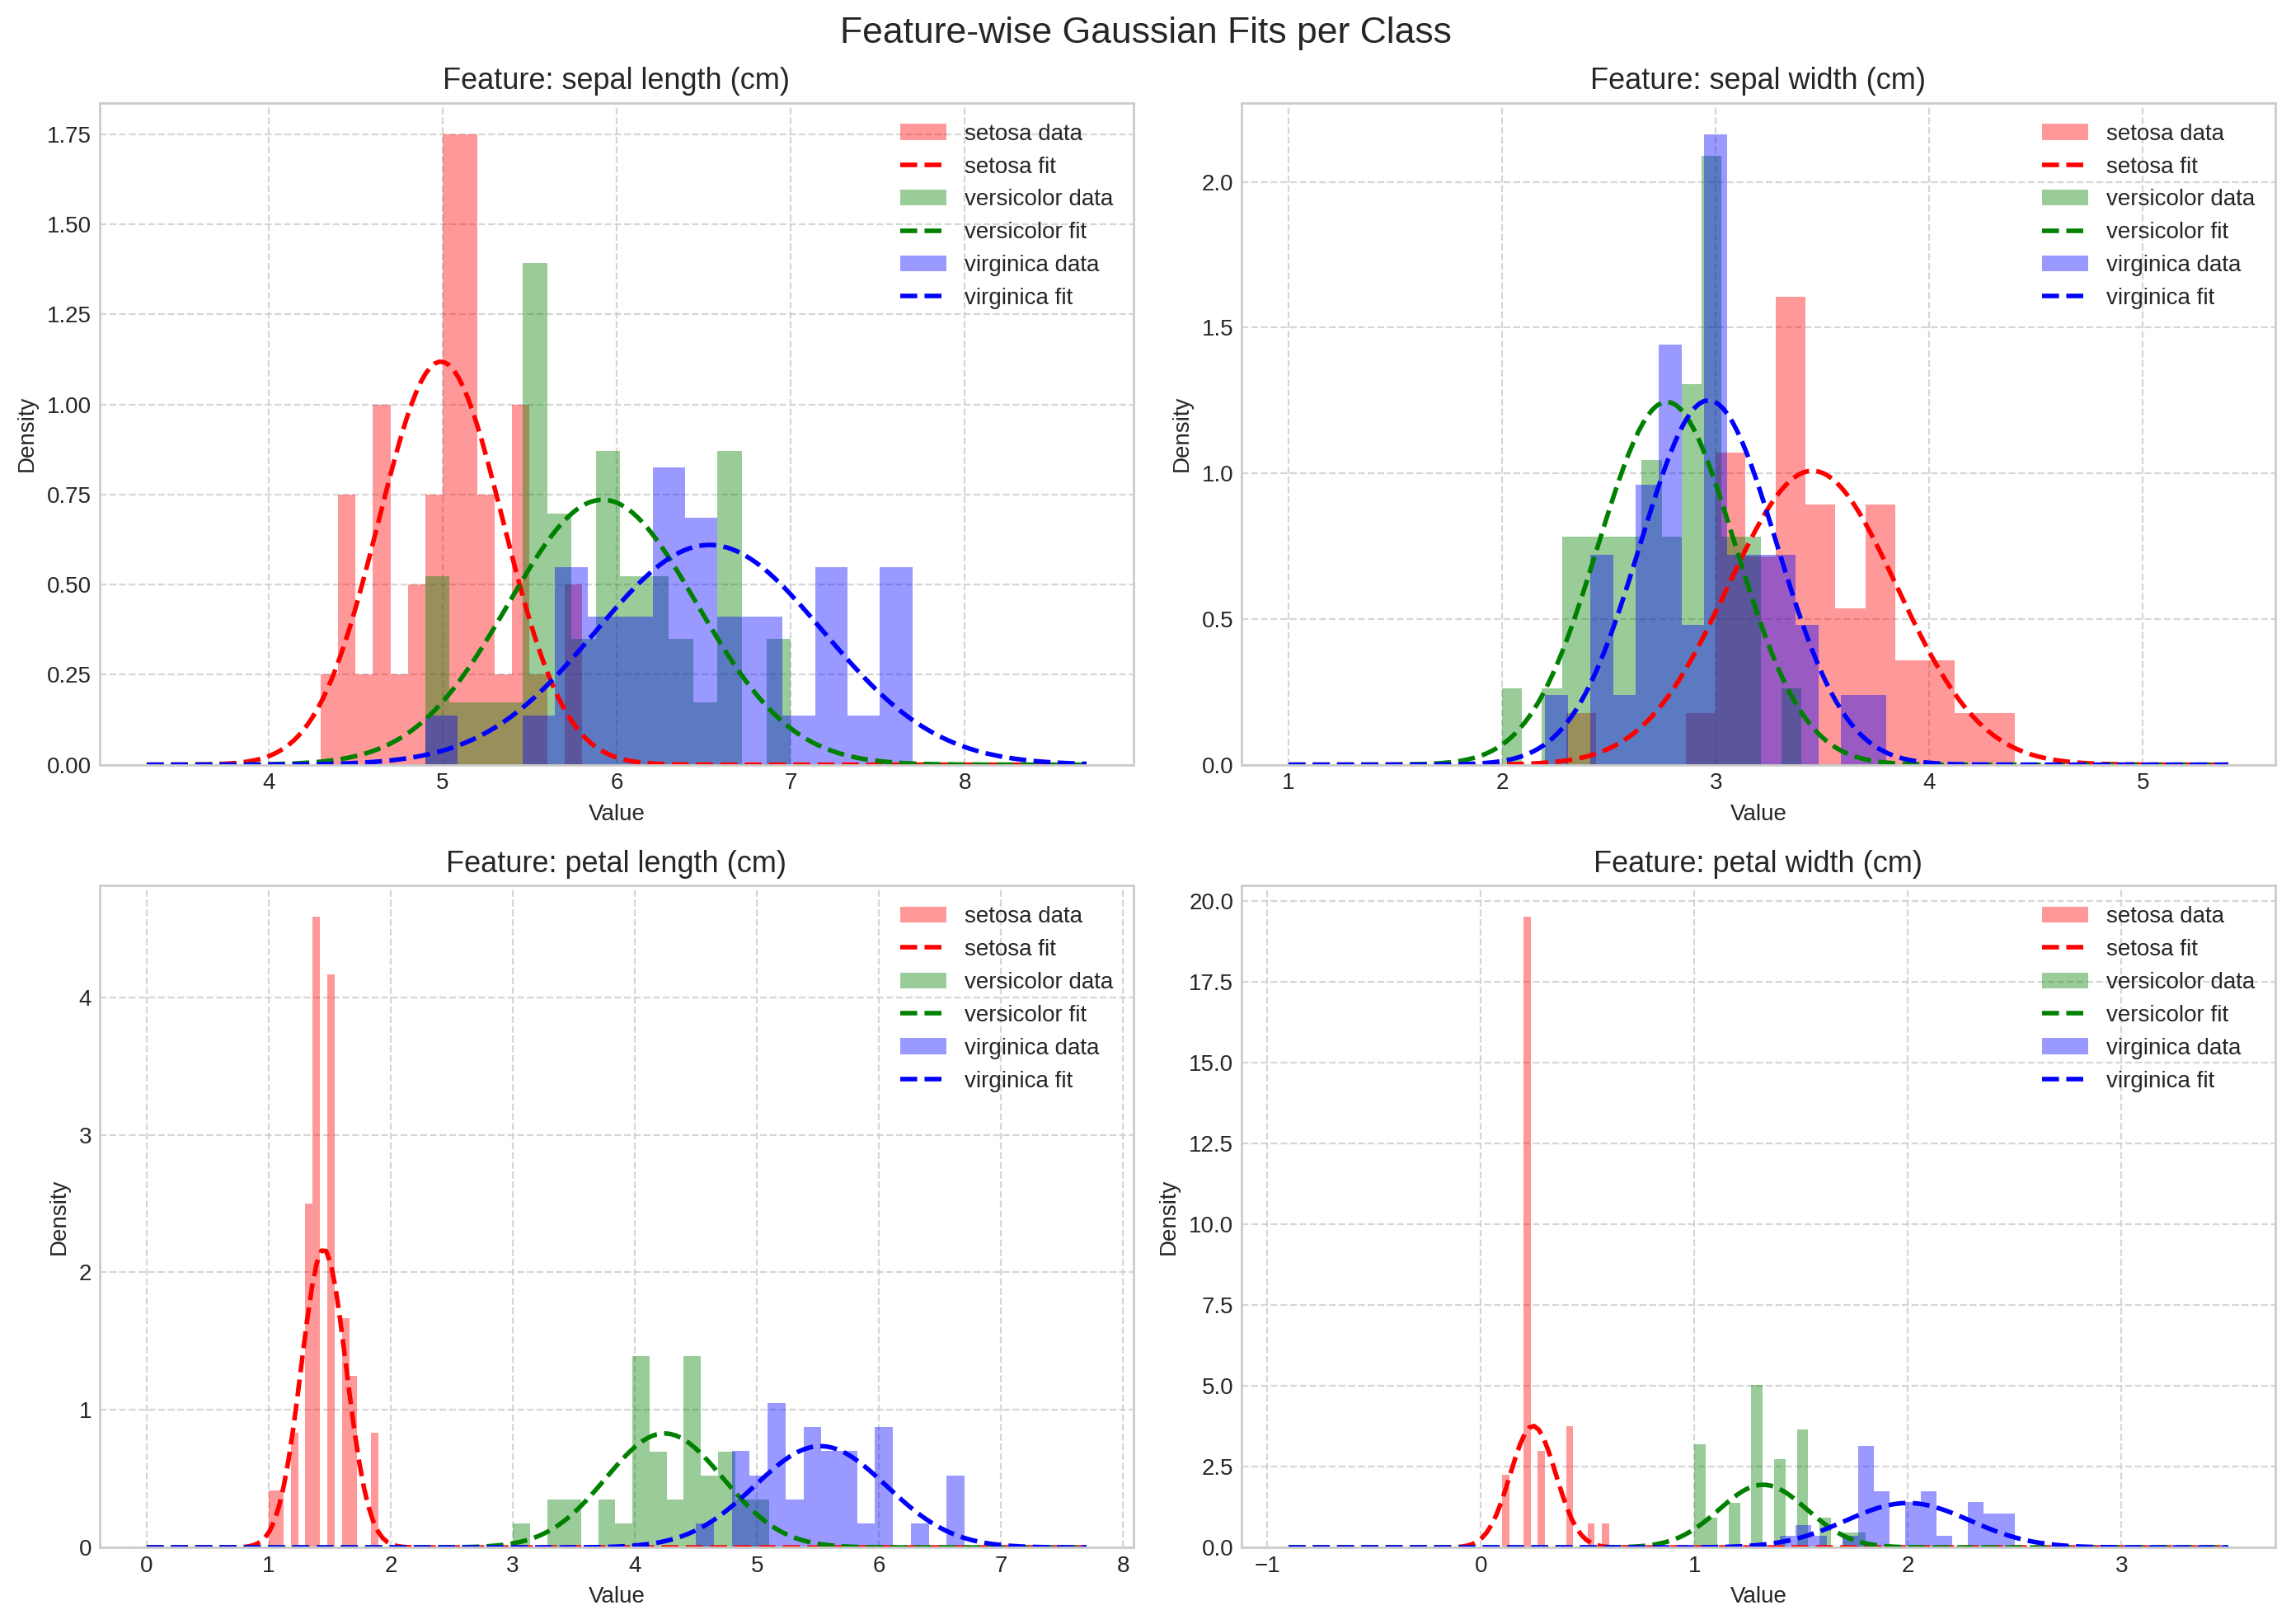

In [ ]:
def plot_feature_fit_with_gaussian():
    plt.style.use("seaborn-v0_8-whitegrid")
    stats = mean_var_per_feature(DATA)
    colors = ['red', 'green', 'blue']

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=200)
    axes = axes.flatten()

    for i, feature in enumerate(feature_names):
        ax = axes[i]

        x_vals = np.linspace(DATA[feature].min() - 1, DATA[feature].max() + 1, 200)

        for cls in range(len(class_names)):
            subset = DATA[DATA["Target"] == cls][feature]
            mean = stats[cls]["mean"][i]
            var = stats[cls]["var"][i]
            y_vals = normal_distribution(x_vals, mean, var)

            ax.hist(subset, bins=15, density=True, alpha=0.4, color=colors[cls], label=f"{class_names[cls]} data")

            ax.plot(x_vals, y_vals, color=colors[cls], linestyle="--", linewidth=2, label=f"{class_names[cls]} fit")

        ax.set_title(f"Feature: {feature}", fontsize=13)
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")
        ax.grid(linestyle="--", alpha=0.8)
        ax.legend()

    plt.suptitle("Feature-wise Gaussian Fits per Class", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_feature_fit_with_gaussian()

## Cross-Validating To Find Out The Mean Accuracy

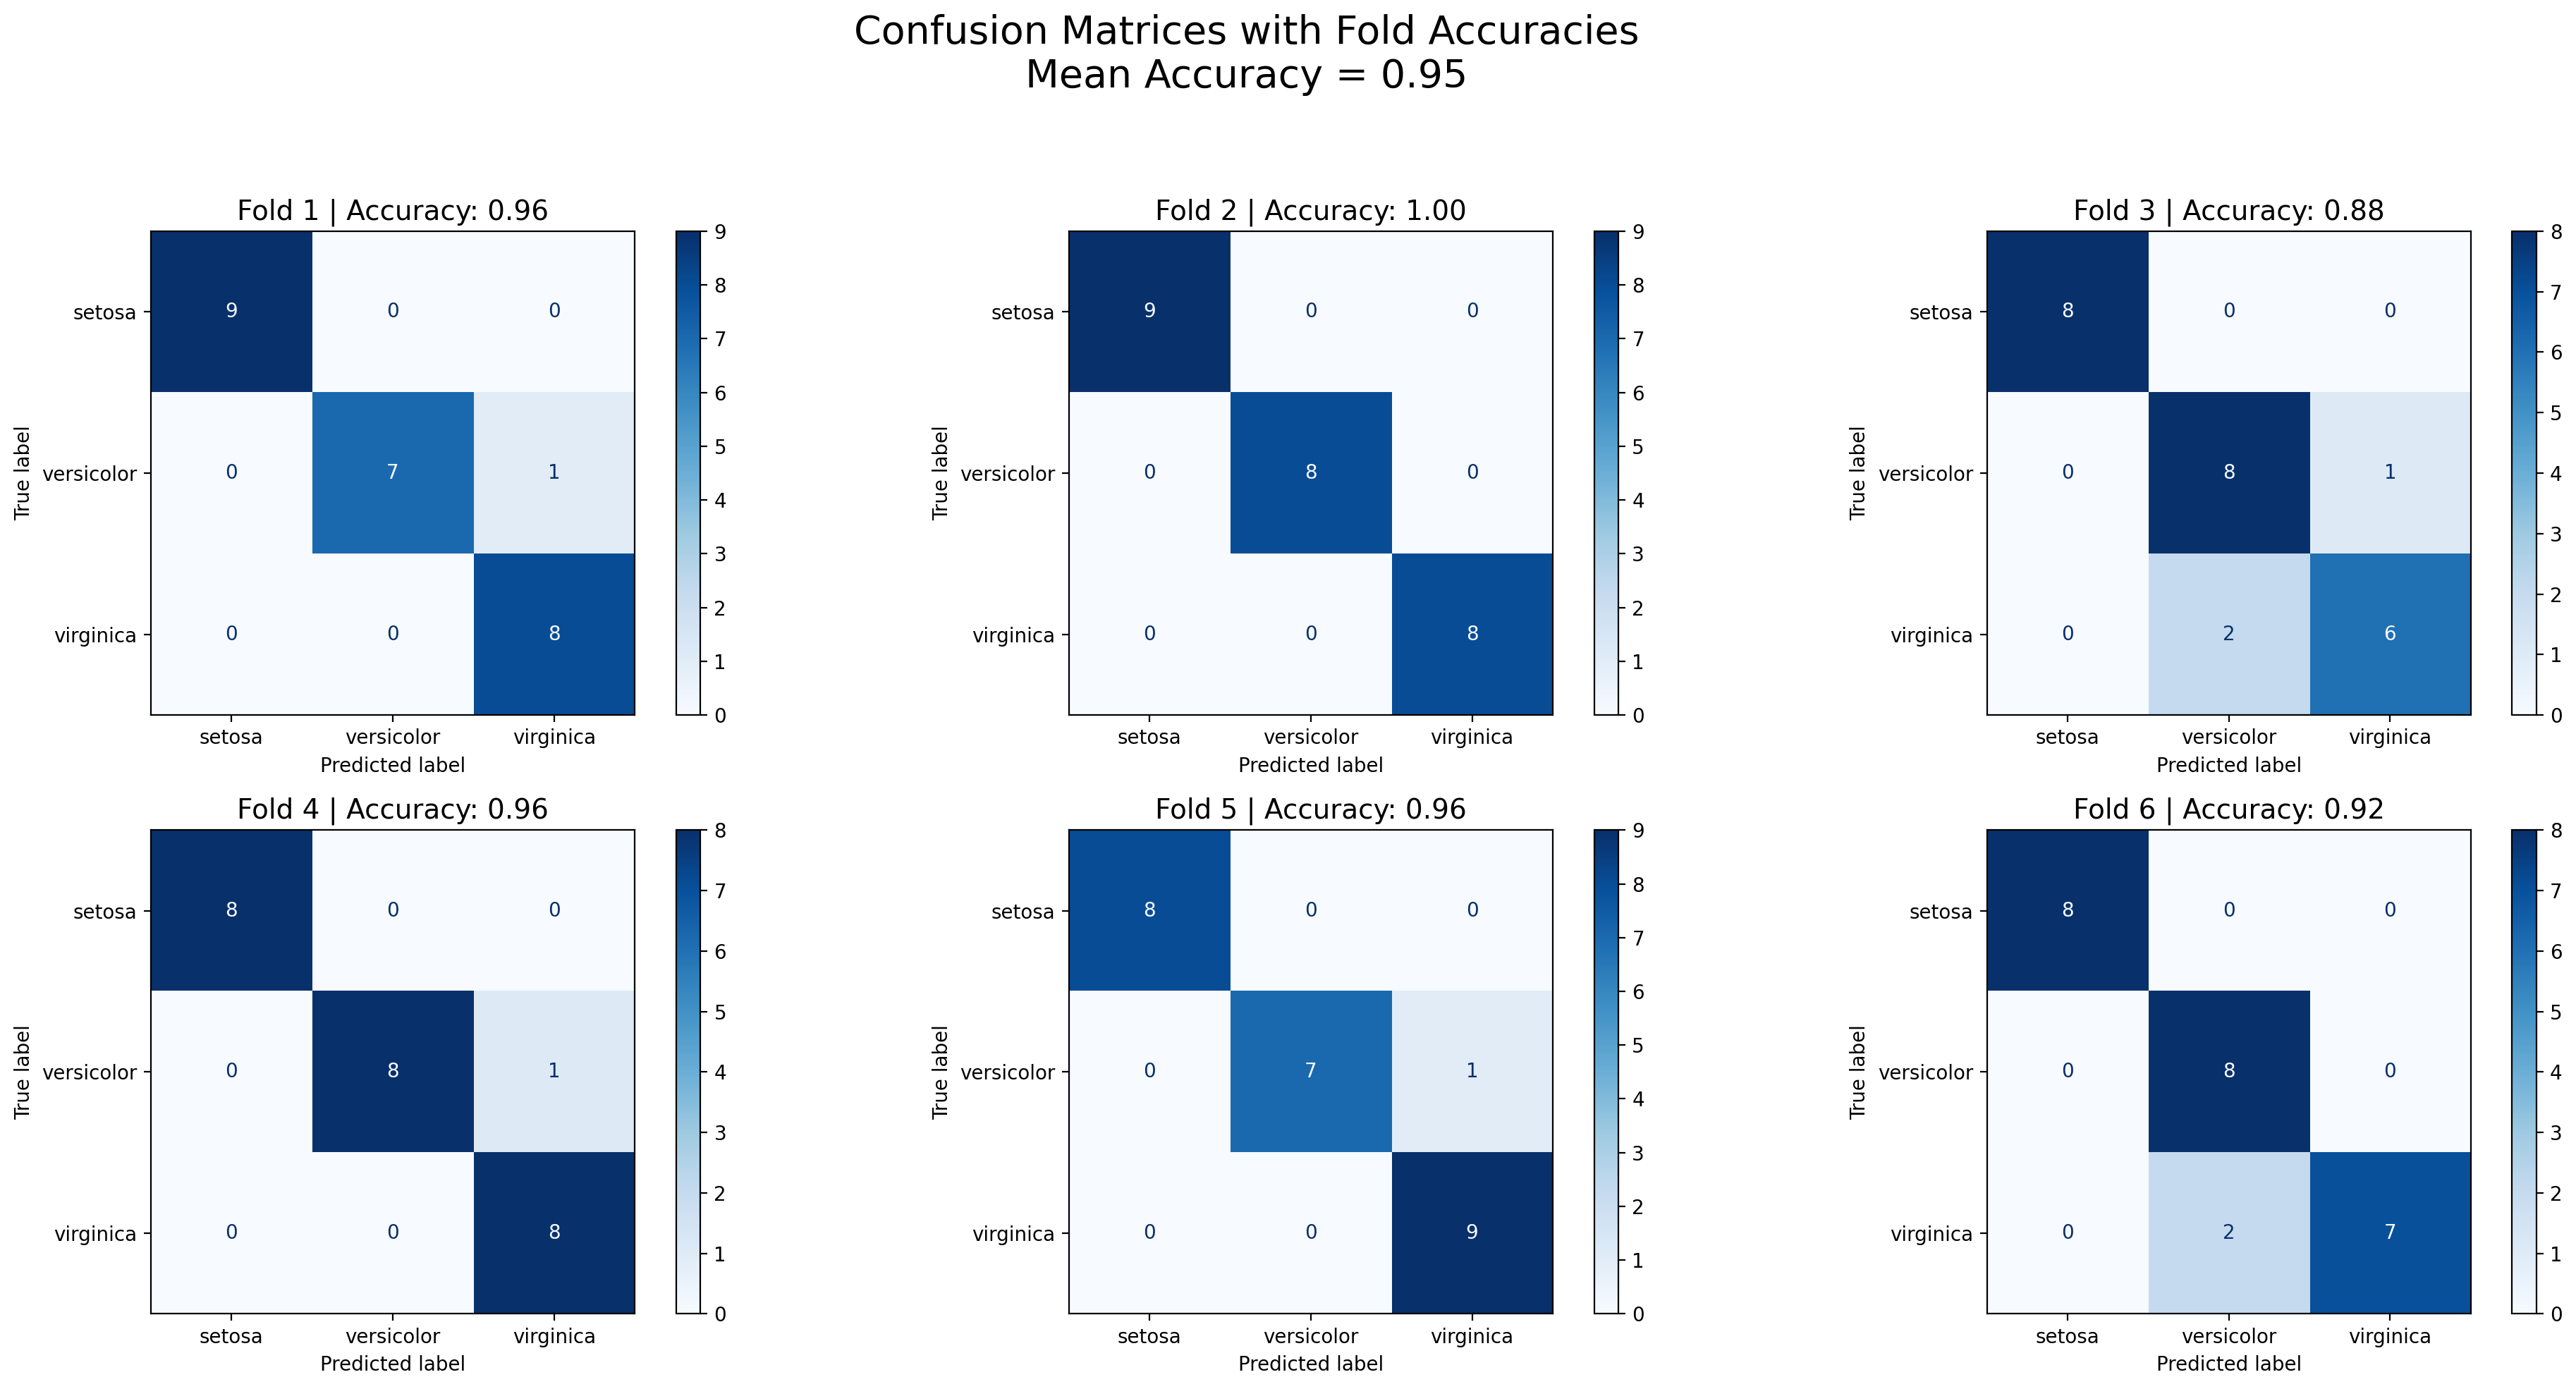

Mean Accuracy: 0.95


In [7]:
def cross_val_confusion_grid(k=6):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fig, axes = plt.subplots(2, 3, figsize=(20, 10), dpi=200)
    axes = axes.flatten()
    accs = []

    for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):
        x_train, x_val = X[train_idx], X[test_idx]
        y_train, y_val = Y[train_idx], Y[test_idx]
        DATA_train = pd.DataFrame(np.column_stack([x_train, y_train]), columns=feature_names + ["Target"])
        preds = np.array([GaussianNB(x_val[j], DATA_train) for j in range(len(x_val))])
        acc = np.sum(preds == y_val) / len(y_val)
        accs.append(acc)

        # Confusion matrix display
        cm = confusion_matrix(y_val, preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(ax=axes[i], cmap="Blues", values_format="d")
        axes[i].set_title(f"Fold {i+1} | Accuracy: {acc:.2f}", fontsize=14)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f"Confusion Matrices with Fold Accuracies\nMean Accuracy = {np.round(np.mean(accs), 2)}\n\n", fontsize=20)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    return accs

accuracies = cross_val_confusion_grid()
print("Mean Accuracy:", np.round(np.mean(accuracies), 2))
